In [1]:
import numpy as np
import sympy as sp
from PIL import Image
from scipy import interpolate
import matplotlib.pyplot as plt
import time
from skimage.metrics import structural_similarity

# Tarea 3:Interpolación Bicúbica

## Instrucciones

* La tarea es individual.
* Las consultas sobre las tareas se deben realizar por medio de la plataforma Aula.
* La tarea debe ser realizada en `Jupyter Notebook` (`Python3`).
* Se evaluará la correcta utilización de librerias `NumPy`, `SciPy`, entre otras, así como la correcta implementación de algoritmos de forma vectorizada.
*  **El archivo de entrega debe denominarse ROL-tarea-numero.ipynb**. _De no respetarse este formato existirá un descuento de **50 puntos**_
* La fecha de entrega es el viernes 24 de Julio a las **18:00 hrs**.  Se aceptarán entregas hasta las 19:00 hrs sin descuento en caso de existir algun problema, posteriormente existirá un descuento lineal hasta las 20:00 hrs del mismo día.
* Las tareas que sean entregadas antes del jueves a mediodía recibirán una bonificación de 10 puntos
* Debe citar cualquier código ajeno utilizado (incluso si proviene de los Jupyter Notebooks del curso).


## Introducción

En la siguiente tarea estudiaremos un método de interpolación denominado **Interpolación Bicúbica**, utilizada frecuentemente sobre imágenes. Aplicaremos el método para aumentar la resolución de una imagen intentando preservar las propiedades de la versión original.

## Contexto

Supongamos que usted conoce $f$ y las derivadas $f_x$, $f_y$ y $f_{xy}$ dentro de las coordenadas $(0,0),(0,1),(1,0)$ y $(1,1)$ de un cuadrado unitario. La superficie que interpola estos 4 puntos es:

$$
p(x,y) = \sum\limits_{i=0}^3 \sum_{j=0}^3 a_{ij} x^i y^j.
$$

Como se puede observar el problema de interpolación se resume en determinar los 16 coeficientes $a_{ij}$ y para esto se genera un total de $16$ ecuaciones utilizando los valores conocidos de $f$,$f_x$,$f_y$ y $f_{xy}$. Por ejemplo, las primeras $4$ ecuaciones son:

$$
\begin{aligned}
f(0,0)&=p(0,0)=a_{00},\\
f(1,0)&=p(1,0)=a_{00}+a_{10}+a_{20}+a_{30},\\
f(0,1)&=p(0,1)=a_{00}+a_{01}+a_{02}+a_{03},\\
f(1,1)&=p(1,1)=\textstyle \sum \limits _{i=0}^{3}\sum \limits _{j=0}^{3}a_{ij}.
\end{aligned}
$$

Para las $12$ ecuaciones restantes se debe utilizar:

$$
\begin{aligned}
f_{x}(x,y)&=p_{x}(x,y)=\textstyle \sum \limits _{i=1}^{3}\sum \limits _{j=0}^{3}a_{ij}ix^{i-1}y^{j},\\
f_{y}(x,y)&=p_{y}(x,y)=\textstyle \sum \limits _{i=0}^{3}\sum \limits _{j=1}^{3}a_{ij}x^{i}jy^{j-1},\\
f_{xy}(x,y)&=p_{xy}(x,y)=\textstyle \sum \limits _{i=1}^{3}\sum \limits _{j=1}^{3}a_{ij}ix^{i-1}jy^{j-1}.
\end{aligned}
$$


Una vez planteadas las ecuaciones, los coeficientes se pueden obtener al resolver el problema $A\alpha=x$, donde $\alpha=\left[\begin{smallmatrix}a_{00}&a_{10}&a_{20}&a_{30}&a_{01}&a_{11}&a_{21}&a_{31}&a_{02}&a_{12}&a_{22}&a_{32}&a_{03}&a_{13}&a_{23}&a_{33}\end{smallmatrix}\right]^T$ y ${\displaystyle x=\left[{\begin{smallmatrix}f(0,0)&f(1,0)&f(0,1)&f(1,1)&f_{x}(0,0)&f_{x}(1,0)&f_{x}(0,1)&f_{x}(1,1)&f_{y}(0,0)&f_{y}(1,0)&f_{y}(0,1)&f_{y}(1,1)&f_{xy}(0,0)&f_{xy}(1,0)&f_{xy}(0,1)&f_{xy}(1,1)\end{smallmatrix}}\right]^{T}}$.


En un contexto más aplicado, podemos hacer uso de la interpolación bicúbica para aumentar la resolución de una imagen. Supongamos que tenemos la siguiente imagen de tamaño $5 \times 5$:

<img src="img1.png" width="20%"/>

Podemos ir tomando segmentos de la imagen de tamaño $2 \times 2$ de la siguiente forma:

<img src="img2.png" width="50%"/>

Por cada segmento podemos generar una superficie interpoladora mediante el algoritmo de interpolación cubica. Para el ejemplo anterior estariamos generando $16$ superficies interpoladoras distintas. La idea es hacer uso de estas superficies para estimar los valores de los pixeles correspondientes a una imagen más grande. Por ejemplo, la imagen $5 \times 5$ la podemos convertir a una imagen de $9 \times 9$ agregando un pixel entre cada par de pixeles originales además de uno en el centro para que no quede un hueco.

<img src="img3.png" width="50%"/>

Aca los pixeles verdes son los mismos que la imagen original y los azules son obtenidos de evaluar cada superficie interpoladora. Notar que existen pixeles azules que se pueden obtener a partir de dos superficies interpoladoras distintas, en esos casos se puede promediar el valor de los pixeles o simplemente dejar uno de los dos. 

Para trabajar con la interpolación bicubica necesitamos conocer los valores de $f_x$, $f_y$ y $f_{xy}$. En el caso de las imagenes solo tenemos acceso al valor de cada pixel por lo que deberemos estimar cual es el valor de estos. Para estimar $f_x$ haremos lo siguiente:

Para estimar el valor de $f_x$ en cada pixel haremos una interpolación con los algoritmos conocidos, usando tres pixels en dirección de las filas, luego derivaremos el polinomio obtenido y finalmente evaluaremos en la posición de interes. La misma idea aplica para $f_y$ solo que ahora interpolaremos en dirección de las columnas.

<img src="img5.png" width="60%"/>

Por ejemplo si queremos obtener el valor de $f_x$ en la posición $(0,0)$ (imagen de la izquierda) entonces haremos una interpolación de Lagrange utilizando los pixeles $(0,0),(0,1)$ y $(0,2)$. Derivaremos el polinomio interpolador y evaluaremos en $(0,0)$. Por otro lado si queremos obtener el valor de $f_y$ en la posición $(0,0)$ (imagen de la derecha) entonces interpolaremos los pixeles $(0,0),(1,0)$ y $(2,0)$. Luego derivaremos el polinomio interpolador y evaluaremos en $(0,0)$.

Para obtener $f_{xy}$ seguiremos la idea anterior. Solo que esta vez se utilizaran los valores de $f_y$ y se interpolaran estos en dirección de las filas.

# Preguntas

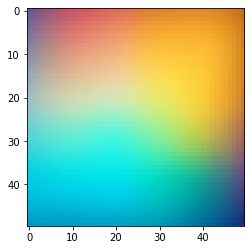

In [2]:
#Codigo para abrir y visualizar imágenes
img = Image.open('imagenes_prueba/gradient.png')
array=np.array(img)
imgplot = plt.imshow(array)
plt.show()

## 1. Interpolación bicubica

### 1.1  Obtener derivadas (30 puntos)

Implemente la función `derivativeValues` que reciba como input un arreglo con valores, el método de interpolación y si es que se considera el uso de  los puntos de chebyshev . La función debe retornar un arreglo de igual dimensión con los valores de las derivadas de los puntos obtenidas

Los métodos de interpolación serán representados por los siguientes valores

* Interpolación de lagrange: `'lagrange'`
* Diferencias divididas de Newton: `'newton'`
* Spline cubica: `'spline3'`


In [3]:

#Código extraído del repositorio del profesor Torres
def Divided_Differences(x, y):
    dd = np.array([y])
    for i in range(len(x)-1):
        ddi = []
        for a in range(len(x)-i-1):
            ddi.append((dd[i][a+1]-dd[i][a])/(x[a+i+1]-x[a]))
        ddi = np.append(ddi,np.full((len(x)-len(ddi),),0.0))
        dd = np.append(dd,[ddi],axis=0)
    return np.array(dd)

#Código extraído del repositorio del profesor Torres
def Newton(x, y, show=False):
    # We calculate the divided differences and store them in a data structure
    dd = Divided_Differences(x,y)
    
    # The function shows the data if the flag is true
    if show:
        print('Data Points: '); print([(x[i],y[i]) for i in range(len(x))])
        xS = sp.Symbol('x')
        N = np.dot(dd[:,0],np.append([1],[np.prod(xS-x[:i]) for i in range(1,len(dd))]))
        print('Interpolation Function: ');
        print(N)
        
    # Finally, we return a data structure with our interpolating polynomial
    D = {'M':'Newton',
         'P':dd[:,0],
         'x':x,
         'y':y}
    return D

#Código extraído del repositorio del profesor Torres
def Chebyshev_points(xmin,xmax,n):
    ns = np.arange(1,n+1)
    x = np.cos((2*ns-1)*np.pi/(2*n))
    #y = np.sin((2*ns-1)*np.pi/(2*n))
    return ((xmin+xmax)/2) + ((xmax-xmin)*x/2)

In [4]:
def derivativeValues(values, method, cheb):
    """
    Parameters
    ----------
    values:	(int array) points values
    method:	(string)	interpolation method
    cheb:	(boolean)	if chebyshev points are used

    Returns
    -------
    d:	(float array) derivative value of interpolated points

    """
    if cheb:
        xValues = np.array(Chebyshev_points(0, len(values)-1, len(values)))
    else:
        xValues = np.array(np.linspace(0, len(values)-1, len(values)))
    xValues = np.sort(xValues)
    if method == 'lagrange':
        P = interpolate.lagrange(xValues, values)
        P = np.poly1d(P)
        Px = P.deriv()  
    if method == 'newton':
        coeficientes = Newton(xValues, values, show=False)['P'] #coef. del polinomio
        Xs = list(xValues)
        del Xs[-1]
        Pn = 0
        while(Xs != []):
            P = 1
            for value in Xs:
                P = np.poly1d([1,-value])*P
            del Xs[-1]
            if len(coeficientes) != 1:
                Pn = Pn + P*coeficientes[-1]
                coeficientes = np.delete(coeficientes,-1)
        Px = Pn.deriv()
    if method == 'spline3':
        P = interpolate.CubicSpline(np.sort(xValues), values)
        Px = P.derivative()
    d=[]
    for value in xValues:
        d.append(Px(value))
    
    return np.array(d)


### 1.2 Interpolación de imagen (50 puntos)
Implemente la función `bicubicInterpolation` que reciba como input la matriz de la imagen y cuantos píxeles extra se quiere agregar entre los píxeles originales y el algoritmo de interpolación a utilizar. La función debe retornar la matriz con la imagen de dimensión nueva. Considere que se debe aplicar el método de interpolación en cada canal RGB por separado.

In [5]:
#Función que recibe una matriz f y obtiene fx interpolando de a 3 puntos
def fx(matriz, method, cheb):
    final = []
    for fila in matriz:
        nFila = []
        largo = len(fila)
        for i in range(largo):
            if (i == 0) or (i == 1) or (i == (largo-1)) or (i == (largo-2)):
                if i == 1:
                    nFila.append( derivativeValues(fila[0:3],method,cheb)[1] )
                if i == 0:
                    nFila.append( derivativeValues(fila[0:3],method,cheb)[0] )
                if i == (largo-2):
                    nFila.append( derivativeValues(fila[largo-3:largo],method,cheb)[1] )
                if i == (largo-1):
                    nFila.append( derivativeValues(fila[largo-3:largo],method,cheb)[2] )
            else:
                nFila.append( derivativeValues(fila[i-1:i+2],method,cheb)[1] )
        final.append(nFila)
    return np.array(final)

#Resuelve Aα=x recolectando todos los elementos X de las matrices recibidas
def coeficientes(f, fx, fy, fxy):
    filas, colum = f.shape
    coeficientes = []
    xs = [] #los xs de Ab=x, cada posicion son todos los xs de ese cuadrado
    A = [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #matriz resultante de aplicar las sumatorias
         [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
         [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3],
         [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0],
         [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0],
         [0, 0, 0, 0, 0, 1, 2, 3, 0, 2, 4, 6, 0, 3, 6, 9]]
    for i in range(filas-1):
        for j in range(colum-1):
            coef = []
            coef1 = []
            coef2 = []
            coef3 = []
            coef.append(f[i][j])
            coef.append(f[i+1][j])
            coef.append(f[i][j+1])
            coef.append(f[i+1][j+1])
            
            coef1.append(fx[i][j])
            coef1.append(fx[i+1][j])
            coef1.append(fx[i][j+1])
            coef1.append(fx[i+1][j+1])
            
            coef2.append(fy[i][j])
            coef2.append(fy[i+1][j])
            coef2.append(fy[i][j+1])
            coef2.append(fy[i+1][j+1])
            
            coef3.append(fxy[i][j])
            coef3.append(fxy[i+1][j])
            coef3.append(fxy[i][j+1])
            coef3.append(fxy[i+1][j+1])
            
            c = coef+coef1+coef2+coef3
            xs.append(c)
    xs = np.array(xs)
    #print("xs")
    #print(xs)
    for i in range(len(xs)):
        b = np.transpose(xs[i])
        res = list(np.linalg.solve(A, b))
        coeficientes.append(res)
    return np.array(coeficientes)

#funcion que recibe los coeficientes (con esto armamos el polinomio) 
#y los puntos a evaluar y devuelve el valor de esa posicion
def evaluar(coef, x, y):
    pol = []
    i = 0
    for k in range(4): # a00 a10 a20 a30
        pol.append( coef[k]*(x**i)*(y**0) )
        i+=1
    i = 0
    for k in range(4,8):#a01 a11 a21 a31
        pol.append( coef[k]*(x**i)*(y**1) )
        i+=1
    i = 0
    for k in range(8,12): #a02 a12 a22 a32
        pol.append( coef[k]*(x**i)*(y**2) )
        i+=1
    i = 0
    for k in range(12,16):#a03 a13 a23 a33
        pol.append( coef[k]*(x**i)*(y**3) )
        i+=1
    return sum(pol)

#funcion que recibe los coeficientes y calcula todos los cuadrados de la matriz expandida
#devuelve estos cuadrados en forma de matriz de matrices
def penultima(coef, interiorPixels):
    matrices = []
    ys = np.linspace(0, 1, interiorPixels+2)
    for filaCoef in coef:
        matriz = []
        for i in range(interiorPixels+2): #i = filas
            fila = []
            for j in range(interiorPixels+2): #j = columnas
                valor = int(evaluar(filaCoef, ys[i], ys[j]))#x, y 
                if valor<0:
                    fila.append(int(0))
                elif valor>255:
                    fila.append(int(255))
                else:
                    fila.append(valor) 
            matriz.append(fila)
        matrices.append(matriz)
    return np.array(matrices)

#funcion que toma los cuadrados y los aplica a la matriz final
def final(cuadrados, image, interiorPixels):
    fil, col, _ = image.shape
    newImage = np.zeros((fil+(interiorPixels*(fil-1)), col+(interiorPixels*(col-1))))
    repeticiones = fil-1 #repeticiones horizontales filas originales!!! de la matriz original
    k = 0
    largoT = interiorPixels+2
    largo = interiorPixels+2
    for j in range(repeticiones): #se repite el numero de filas
        kc = 0
        largoc = interiorPixels+2
        for i in range(repeticiones): #se repite el numero de columnas
            newImage[k:largo, kc:largoc] = cuadrados[i]
            kc = kc + largoT - 1
            largoc = largoc + largoT-1
        for n in range(repeticiones):
            cuadrados = np.delete(cuadrados, 0, 0)
        k = k+largoT - 1
        largo = largo + largoT -1 
    return newImage

#junta las 3 matrices en una como la original
def reconstruccion(rojo, verde, azul):
    f, _ = rojo.shape
    matriz = []
    for i in range(f):
        fila = []
        for j in range(f):
            rgb = []
            rgb.append(rojo[i][j])
            rgb.append(verde[i][j])
            rgb.append(azul[i][j])
            fila.append(np.array(rgb))
        matriz.append(np.array(fila))
    return np.array(matriz)

In [6]:
def bicubicInterpolation(image, interiorPixels, method,cheb):
    """
    Parameters
    ----------
    image:	(nxnx3 array) image array in RGB format
    interiorPixels:	(int)	interpolation method
    method:	(string)	interpolation method
    cheb:	(boolean)	if chebyshev points are used


    Returns
    -------
    newImage:	(nxnx3 array) image array in RGB format

    """
    #f
    imageRoja = []
    imageVerde = []
    imageAzul = []
    for fila in image:
        nFila = []
        for elem in fila:
            nFila.append(elem[0])
        imageRoja.append(nFila)
    for fila in image:
        nFila = []
        for elem in fila:
            nFila.append(elem[1])
        imageVerde.append(nFila)
    for fila in image:
        nFila = []
        for elem in fila:
            nFila.append(elem[2])
        imageAzul.append(nFila)
    imageRoja = np.array(imageRoja).astype(int)
    imageVerde = np.array(imageVerde).astype(int)
    imageAzul = np.array(imageAzul).astype(int)
    #fx
    imageRojaX = fx(imageRoja, method, cheb)
    imageVerdeX = fx(imageVerde, method, cheb)
    imageAzulX = fx(imageAzul, method, cheb)
    #fy
    imageRojaY = np.transpose(fx(np.transpose(imageRoja), method, cheb))
    imageVerdeY = np.transpose(fx(np.transpose(imageVerde), method, cheb))
    imageAzulY = np.transpose(fx(np.transpose(imageAzul), method, cheb))
    #fxy
    imageRojaXy = fx(imageRojaY, method, cheb)
    imageVerdeXy = fx(imageVerdeY, method, cheb)
    imageAzulXy = fx(imageAzulY, method, cheb)
    #Resolvemos Aα=x para cada cuadrao 2x2 guardando los coeficientes en una matriz
    coefRojo = coeficientes(imageRoja, imageRojaX, imageRojaY, imageRojaXy)
    #print("coeficientes rojos")
    #print(coefRojo)
    coefVerde = coeficientes(imageVerde, imageVerdeX, imageVerdeY, imageVerdeXy)
    coefAzul = coeficientes(imageAzul, imageAzulX, imageAzulY, imageAzulXy)
    #calculamos todos los cuadrados vacios
    cuadradosRojos = penultima(coefRojo, interiorPixels)
    cuadradosVerde = penultima(coefVerde, interiorPixels)
    cuadradosAzul = penultima(coefAzul, interiorPixels)
    #generamos las matrices extendidas resultantes por cada color
    rojo = final(cuadradosRojos, image, interiorPixels)
    verde = final(cuadradosVerde, image, interiorPixels)
    azul = final(cuadradosAzul, image, interiorPixels)
    #volvemos la matriz a su estructura original RGB
    newImage = (reconstruccion(rojo, verde, azul)).astype(int)
    return newImage

## 2. Evaluacion de algoritmos



### 2.1 Tiempo de ejecucion 
Implemente la funcion `timeInterpolation` que mida el tiempo de interpolacion de una imagen dado el algoritmo de interpolacion en segundos.(5 puntos)

In [7]:
def timeInterpolation(image, interiorPixels, method,cheb):
    """
    Parameters
    ----------
    image:	(nxnx3 array) image array in RGB format
    interiorPixels:	(int)	interpolation method
    method:	(string)	interpolation method
    cheb:	(boolean)	if chebyshev points are used


    Returns
    -------
    time:	(float) time in seconds

    """
    
    comienzo = time.time()

    a = bicubicInterpolation(image, interiorPixels, method, cheb)

    termino = time.time()

    tiempo =  termino - comienzo 
    return tiempo

***Pregunta: ¿Cual es el metodo que presenta mayor velocidad en general? (5 puntos)***

Utilizaremos los tres métodos con y sin chebyshev con 1 y 2 pixeles interiores por cada imágen:

In [99]:
metodos = ['lagrange', 'newton', 'spline3']
cat = Image.open('imagenes_prueba/cat.png').convert('RGB')
gradient = Image.open('imagenes_prueba/gradient.png')
sunset = Image.open('imagenes_prueba/sunset.png')

#### Imágen: cat.png

In [100]:
for metodo in metodos:
    for i in range(2):
        print("El método utilizado: ", metodo)
        print("Pixeles interiores utilizados: ", i+1)
        print("Puntos de chebyshev(0 es No y 1 es Sí): ", i)
        print("Tiempo total: ",timeInterpolation(np.array(cat), i+1, metodo, i)," s")
        print("---------------------------------------------")

El método utilizado:  lagrange
Pixeles interiores utilizados:  1
Puntos de chebyshev(0 es No y 1 es Sí):  0
Tiempo total:  12.405929565429688  s
---------------------------------------------
El método utilizado:  lagrange
Pixeles interiores utilizados:  2
Puntos de chebyshev(0 es No y 1 es Sí):  1
Tiempo total:  13.477872371673584  s
---------------------------------------------
El método utilizado:  newton
Pixeles interiores utilizados:  1
Puntos de chebyshev(0 es No y 1 es Sí):  0
Tiempo total:  9.428178787231445  s
---------------------------------------------
El método utilizado:  newton
Pixeles interiores utilizados:  2
Puntos de chebyshev(0 es No y 1 es Sí):  1
Tiempo total:  9.548043489456177  s
---------------------------------------------
El método utilizado:  spline3
Pixeles interiores utilizados:  1
Puntos de chebyshev(0 es No y 1 es Sí):  0
Tiempo total:  8.383164405822754  s
---------------------------------------------
El método utilizado:  spline3
Pixeles interiores util

##### En este caso gana Splines cúbicas.

#### Imágen: gradient.png

In [101]:
for metodo in metodos:
    for i in range(2):
        print("El método utilizado: ", metodo)
        print("Pixeles interiores utilizados: ", i+1)
        print("Puntos de chebyshev(0 es No y 1 es Sí): ", i)
        print("Tiempo total en segundos: ",timeInterpolation(np.array(gradient), i+1, metodo, i))
        print("---------------------------------------------")

El método utilizado:  lagrange
Pixeles interiores utilizados:  1
Puntos de chebyshev(0 es No y 1 es Sí):  0
Tiempo total en segundos:  11.194931983947754
---------------------------------------------
El método utilizado:  lagrange
Pixeles interiores utilizados:  2
Puntos de chebyshev(0 es No y 1 es Sí):  1
Tiempo total en segundos:  11.705691814422607
---------------------------------------------
El método utilizado:  newton
Pixeles interiores utilizados:  1
Puntos de chebyshev(0 es No y 1 es Sí):  0
Tiempo total en segundos:  8.541957378387451
---------------------------------------------
El método utilizado:  newton
Pixeles interiores utilizados:  2
Puntos de chebyshev(0 es No y 1 es Sí):  1
Tiempo total en segundos:  9.127081871032715
---------------------------------------------
El método utilizado:  spline3
Pixeles interiores utilizados:  1
Puntos de chebyshev(0 es No y 1 es Sí):  0
Tiempo total en segundos:  8.403976917266846
---------------------------------------------
El métod

##### En este caso gana Splines cúbicas en ambos casos.

#### Imágen: sunset.png

In [102]:
for metodo in metodos:
    for i in range(2):
        print("El método utilizado: ", metodo)
        print("Pixeles interiores utilizados: ", i+1)
        print("Puntos de chebyshev(0 es No y 1 es Sí): ", i)
        print("Tiempo total: ",timeInterpolation(np.array(sunset), i+1, metodo, i)," s")
        print("---------------------------------------------")

El método utilizado:  lagrange
Pixeles interiores utilizados:  1
Puntos de chebyshev(0 es No y 1 es Sí):  0
Tiempo total:  44.708736181259155  s
---------------------------------------------
El método utilizado:  lagrange
Pixeles interiores utilizados:  2
Puntos de chebyshev(0 es No y 1 es Sí):  1
Tiempo total:  47.448498487472534  s
---------------------------------------------
El método utilizado:  newton
Pixeles interiores utilizados:  1
Puntos de chebyshev(0 es No y 1 es Sí):  0
Tiempo total:  34.62664270401001  s
---------------------------------------------
El método utilizado:  newton
Pixeles interiores utilizados:  2
Puntos de chebyshev(0 es No y 1 es Sí):  1
Tiempo total:  37.17723894119263  s
---------------------------------------------
El método utilizado:  spline3
Pixeles interiores utilizados:  1
Puntos de chebyshev(0 es No y 1 es Sí):  0
Tiempo total:  33.822211503982544  s
---------------------------------------------
El método utilizado:  spline3
Pixeles interiores uti

##### En este caso gana Splines cúbicas en ambos casos.

###### Conclusión: El método de Splines cúbicas presenta los tiempos menores la mayoría de veces, por lo que es el método más rápido. Sin embargo, Newton es muy cercano.

### 2.2 Calculo de error
Implemente la funcion `errorInterpolation` la cual debe obtener el error de la imagen obtenida comparandola con una de referencia. El error debe ser calculado utilizando el indice SSIM (Structural similarity) (5 puntos)

In [8]:
def errorInterpolation(original,new):
    """
    Parameters
    ----------
    image:	(nxn array) original image array in RGB format
    new:	(nxn array) new image array in RGB format obtained from interpolation


    Returns
    -------
    error:	(float) difference between images 

    """
    n, _, _ = original.shape
    ssim = structural_similarity(original,new,multichannel=True,data_range=n)
    error = 1-ssim
    return error

***Pregunta: ¿Cual metodo presenta menor error? (5 puntos)***

Compararemos las imágenes de "_1pixel" con la imágen original utilizando los 3 metodos con y sin chebyshev y 1 pixel interior:

In [104]:
metodos = ['lagrange', 'newton', 'spline3']
cat = Image.open('imagenes_prueba/cat_1pixel.png').convert('RGB')
gradient = Image.open('imagenes_prueba/gradient_1pixel.png')
sunset = Image.open('imagenes_prueba/sunset_1pixel.png')
catNew = Image.open('imagenes_prueba/cat.png').convert('RGB')
gradientNew = Image.open('imagenes_prueba/gradient.png')
sunsetNew = Image.open('imagenes_prueba/sunset.png')

#### Imágen: cat.png

In [105]:
for metodo in metodos:
    for i in range(2):
        print("El método utilizado: ", metodo)
        print("Pixeles interiores utilizados: ", 1)
        print("Puntos de chebyshev(0 es No y 1 es Sí): ", i)
        print("Error: ",errorInterpolation(np.array(cat), bicubicInterpolation(np.array(catNew), 1, metodo, i) ))
        print("---------------------------------------------")

El método utilizado:  lagrange
Pixeles interiores utilizados:  1
Puntos de chebyshev(0 es No y 1 es Sí):  0
Error:  0.18621128977694867
---------------------------------------------
El método utilizado:  lagrange
Pixeles interiores utilizados:  1
Puntos de chebyshev(0 es No y 1 es Sí):  1
Error:  0.1916669542034487
---------------------------------------------
El método utilizado:  newton
Pixeles interiores utilizados:  1
Puntos de chebyshev(0 es No y 1 es Sí):  0
Error:  0.18621128977694867
---------------------------------------------
El método utilizado:  newton
Pixeles interiores utilizados:  1
Puntos de chebyshev(0 es No y 1 es Sí):  1
Error:  0.18890284654847223
---------------------------------------------
El método utilizado:  spline3
Pixeles interiores utilizados:  1
Puntos de chebyshev(0 es No y 1 es Sí):  0
Error:  0.18621024250593188
---------------------------------------------
El método utilizado:  spline3
Pixeles interiores utilizados:  1
Puntos de chebyshev(0 es No y 1 

##### Newton y Splines cúbicas presentan errores similares (Splines cúbicas levemente menor en un caso), mientras que lagrange tiene mayor error en este caso.

#### Imágen: gradient.png

In [106]:
for metodo in metodos:
    for i in range(2):
        print("El método utilizado: ", metodo)
        print("Pixeles interiores utilizados: ", 1)
        print("Puntos de chebyshev(0 es No y 1 es Sí): ", i)
        print("Error: ",errorInterpolation(np.array(gradient), bicubicInterpolation(np.array(gradientNew), 1, metodo, i) ))
        print("---------------------------------------------")

El método utilizado:  lagrange
Pixeles interiores utilizados:  1
Puntos de chebyshev(0 es No y 1 es Sí):  0
Error:  0.009002519666592601
---------------------------------------------
El método utilizado:  lagrange
Pixeles interiores utilizados:  1
Puntos de chebyshev(0 es No y 1 es Sí):  1
Error:  0.009284108399750024
---------------------------------------------
El método utilizado:  newton
Pixeles interiores utilizados:  1
Puntos de chebyshev(0 es No y 1 es Sí):  0
Error:  0.009002519666592601
---------------------------------------------
El método utilizado:  newton
Pixeles interiores utilizados:  1
Puntos de chebyshev(0 es No y 1 es Sí):  1
Error:  0.009075135313849736
---------------------------------------------
El método utilizado:  spline3
Pixeles interiores utilizados:  1
Puntos de chebyshev(0 es No y 1 es Sí):  0
Error:  0.009002519666592601
---------------------------------------------
El método utilizado:  spline3
Pixeles interiores utilizados:  1
Puntos de chebyshev(0 es N

##### En este caso Newton y Splines cúbicas son similares nuevamente, donde este último tiene un error un poco menor.

#### Imágen: sunset.png

In [107]:
for metodo in metodos:
    for i in range(2):
        print("El método utilizado: ", metodo)
        print("Pixeles interiores utilizados: ", 1)
        print("Puntos de chebyshev(0 es No y 1 es Sí): ", i)
        print("Error: ",errorInterpolation(np.array(sunset), bicubicInterpolation(np.array(sunsetNew), 1, metodo, i) ))
        print("---------------------------------------------")

El método utilizado:  lagrange
Pixeles interiores utilizados:  1
Puntos de chebyshev(0 es No y 1 es Sí):  0
Error:  0.07399159551791679
---------------------------------------------
El método utilizado:  lagrange
Pixeles interiores utilizados:  1
Puntos de chebyshev(0 es No y 1 es Sí):  1
Error:  0.07457252840005013
---------------------------------------------
El método utilizado:  newton
Pixeles interiores utilizados:  1
Puntos de chebyshev(0 es No y 1 es Sí):  0
Error:  0.07399159551791679
---------------------------------------------
El método utilizado:  newton
Pixeles interiores utilizados:  1
Puntos de chebyshev(0 es No y 1 es Sí):  1
Error:  0.07455597777620981
---------------------------------------------
El método utilizado:  spline3
Pixeles interiores utilizados:  1
Puntos de chebyshev(0 es No y 1 es Sí):  0
Error:  0.07399260616700465
---------------------------------------------
El método utilizado:  spline3
Pixeles interiores utilizados:  1
Puntos de chebyshev(0 es No y 1

##### Newton y Splines cúbicas similares nuevamente (primer caso el menor error es de Newton y el segundo caso el menor error es de Spline cúbica).

##### Como conclusión, utilizar los métodos de Newton y Splines cúbicas dan errores diferentes pero donde esa diferencia es casi imperceptible aunque levemente menor para Splines cúbicas en algunos casos. Lagrange entrega errores más altos que estos dos métodos en algunos casos.

# Consideraciones

* Solo trabajaremos con imagenes cuadradas
* En el caso que el valor interpolado de un punto sea mayor a 255 o menor a 0, este se trunca a 255 o 0 respectivamente
* Esta permitido el uso de sympy para calcular derivadas y para construir el polinomio interpolador 
* El calculo de error puede ser calculado utilizando la imagen en escala de grises [(ejemplo)](https://scikit-image.org/docs/dev/auto_examples/transform/plot_ssim.html)

In [10]:
metodos = ['lagrange', 'newton', 'spline3']
cat = Image.open('imagenes_prueba/cat_4pixel.png').convert('RGB')
gradient = Image.open('imagenes_prueba/gradient_4pixel.png')
sunset = Image.open('imagenes_prueba/sunset_2pixel.png')

catNew = np.array(Image.open('imagenes_prueba/cat.png').convert('RGB'))
gradientNew = np.array(Image.open('imagenes_prueba/gradient.png'))
sunsetNew = np.array(Image.open('imagenes_prueba/sunset.png'))

In [11]:
uno=bicubicInterpolation(catNew, 4, 'newton', 0)
dos=bicubicInterpolation(gradientNew, 4,'newton', 0)
tres=bicubicInterpolation(sunsetNew, 2,'newton', 0)

In [12]:
print(errorInterpolation(np.array(cat),uno))
print(errorInterpolation(np.array(gradient),dos))
print(errorInterpolation(np.array(sunset),tres))

0.3104527007593342
0.011020640340876686
0.08865682555985444


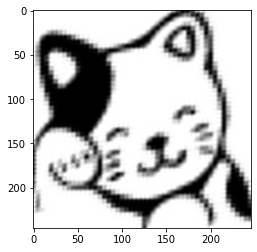

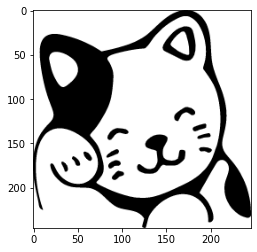

In [14]:
#img = Image.open('imagenes_prueba/gradient.png')
#array=np.array(img)
imgplot = plt.imshow(uno)
plt.show()
fdt = plt.imshow(np.array(cat))
plt.show()